# Processing normalized 3C images for loop recognition

In [26]:
# Import libraries
from pathlib import Path
import os
from pathlib import Path
from pylab import loadtxt
import numpy as np
import json
import numpy as np
import matplotlib.pyplot as plt
from pylab import *  

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)

Populating the interactive namespace from numpy and matplotlib


/Users/zx5281/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['info', 'random', 'linalg', 'fft', 'power']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Data preprocessing

### Normalization method

In [27]:
# .............................. #
# ... Normalisation function ... #
# .............................. #

# A is the matrix to normalise  
# the treshold to remove bins for the normalization (these bins are replaced by zeros vectors)
     
def scn_func(A,threshold):  
    
    n1 = A.shape[0];
    n_iterations=10;
    keep = np.zeros((n1, 1));
    
    for i in range(0,n1) :
        if np.sum(A[i,]) > threshold:
            keep[i] = 1
        else :
            keep[i] = 0
    
    indices1=np.where(keep >0 )
    indices2=np.where(keep <=0 )
    
    for n in range(0,n_iterations) :
        print(n);
        for i in range(0,n1) :
            A[indices1[0],i]=A[indices1[0],i]/ np.sum(A[indices1[0],i])
            A[indices2[0],i]=0   
        A[np.isnan(A)] = 0.0 
        
        for i in range(0,n1) :    
            A[i,indices1[0]]=A[i,indices1[0]]/ np.sum(A[i,indices1[0]])
            A[i,indices2[0]]=0  
        A[np.isnan(A)] = 0.0    
        
    return A

In [28]:
# ................................ #
# ... Detrend with Genomic law ... #
# ................................ #

def dist_law(A):
    
    n1 = A.shape[0];
    print("Size of the matrix entetered for the genomic distance law:")
    print(n1)
    dist = np.zeros((n1, 1));
    for nw in range(0,n1) :   # scales
        somme = [];         
        for i in range(0,n1) :
                kp= i -nw;
                if kp >= 0 and  kp < n1 :       
                    somme.append(A[i,kp]);
        dist[nw] = np.mean(somme)
        
    return dist

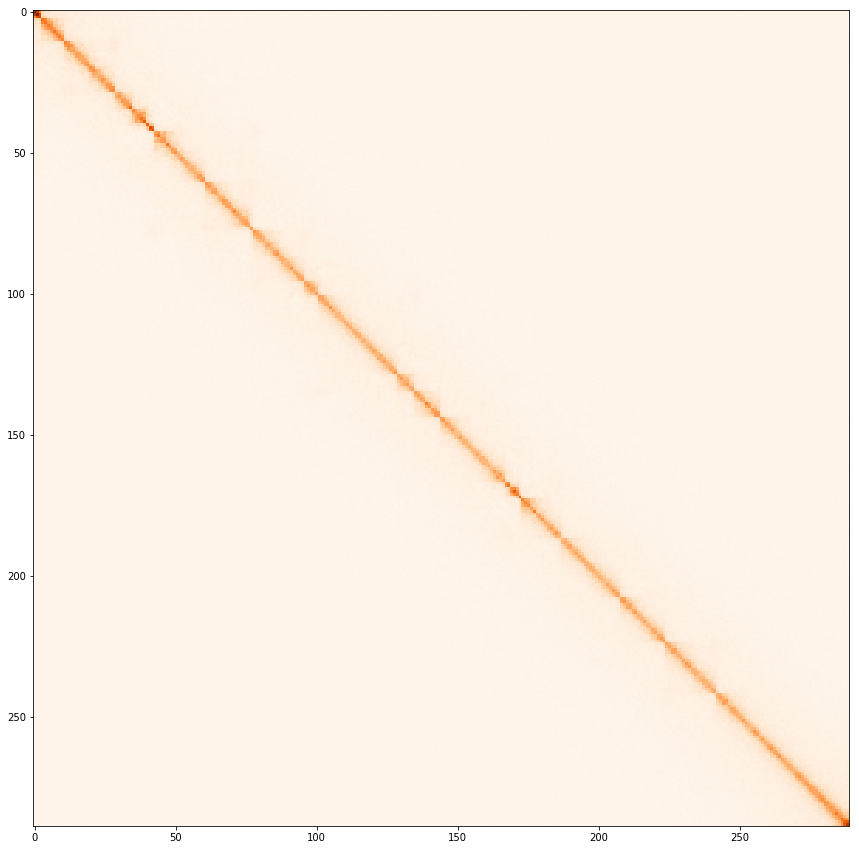

In [30]:
# Select random raw file
path_input = os.path.join(os.getcwd(), 'data/Raw_training')
file = os.path.join(path_input, 'MAT_RAW_realisation_110.txt')

# Study raw file
load_file = loadtxt(file)
plt.imshow(load_file, cmap='Oranges')

0
1
2
3
4
5
6
7
8
9
Size of the matrix entetered for the genomic distance law:
289


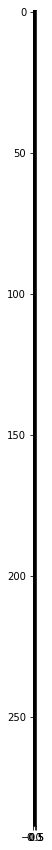

In [33]:
# ... Normalized ... #
normalized = scn_func(load_file, threshold=10)

# ... Detrend ... #
detrended = dist_law(normalized)

plt.imshow(detrended, cmap='gray')

## Template matching

In [ ]:
def find_suspect(mugshot, path_crimescene):
    
    crimescene = loadtxt(path_crimescene)
    im = Image.fromarray(crimescene).convert('RGB')
    im.save("whatever.png")
    crimescene = cv2.imread('whatever.png', 0)
    im = Image.fromarray(mugshot).convert('RGB')
    im.save("whatever.png")
    mugshot = cv2.imread('whatever.png', 0)
    img2 = crimescene.copy()
    template = mugshot
    w, h = template.shape[::-1]
    # All the 6 methods for comparison in a list
    meth = 'cv2.TM_CCOEFF'#, 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
    #{'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv2.matchTemplate(img, template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    values = sorted(np.unique(res), reverse=True)
    for max_val in values:
        loc = np.where(res == max_val)
        max_loc = (loc[1][0], loc[0][0])
        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(img, top_left, bottom_right, 255, 2)
        plt.subplot(121), plt.imshow(res, cmap='gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(img, cmap='gray')
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
        plt.suptitle(meth)
        plt.show()
    return